In [12]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import glob

In [32]:
# Load data
def load_data(data_path):
    if os.path.isfile(data_path):
        data = np.genfromtxt(data_path, names=True, delimiter=",")
        return data
    else:
        return None
    
def load_csv_files(directory, data_type):
    csv_files = glob.glob(os.path.join(directory, '*' + data_type + '.csv'))

    data_dict = {}

    for csv_file in csv_files:
        data = load_data(csv_file)
        label = os.path.splitext(os.path.basename(csv_file))[0]
        label = label[:label.rfind(data_type)-1]
        data_dict[label] = data

    if len(data_dict) == 0:
        print("Failed to load any data!")

    return data_dict
    
folder = ""
data_dict_imu = load_csv_files(folder, "imu")
data_dict_stability = load_csv_files(folder, "stability")
print(f"Loaded {len(data_dict_imu)} imu datasets.")
for label, data_imu in data_dict_imu.items():
    print(label)
print(f"Loaded {len(data_dict_stability)} stability datasets.")
for label, data_imu in data_dict_stability.items():
    print(label)

Loaded 2 imu datasets.
teleop_trial-0
whole_body_assistance_trial-0
Loaded 2 stability datasets.
whole_body_assistance_trial-0
teleop_trial-0


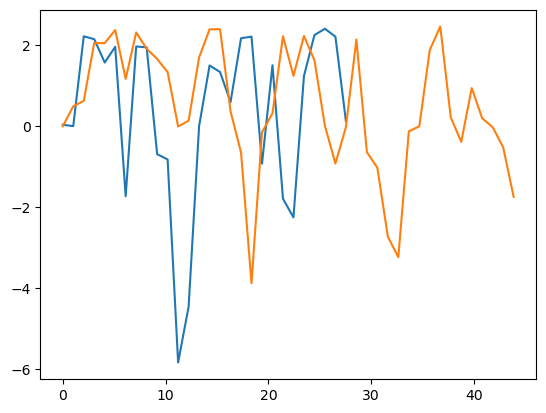

In [30]:
# Stability plot
# Raw relative probability per sample
fig, ax = plt.subplots()
for label, data in data_dict_stability.items():
    ax.plot(data["time"], data["stability"], label=label)
plt.show()

In [31]:
# Compute trial metrics
def compute_metrics(data_imu, data_stability):
    # time
    duration = max(data_imu["time"][-1], data_stability["time"][-1])
    print(f" -- Duration: {duration:.2f}s")

    # Average stability
    avg_stability = np.mean(data_stability["stability"])
    print(f" -- Avg. stability: {avg_stability:.2f}")

    # Locomotion roughness

for label, data_imu in data_dict_imu.items():
    print(f"Trial {label} metrics:")
    data_stability = data_dict_stability[label]
    compute_metrics(data_imu, data_stability) 

Trial teleop_trial-0 metrics:
 -- Duration: 44.44s
 -- Avg. stability: 0.51
Trial whole_body_assistance_trial-0 metrics:
 -- Duration: 28.92s
 -- Avg. stability: 0.39


In [ ]:
#